In [1]:
from cobalt_tractography.bossHandler import *
from cobalt_tractography.tractography import *
import numpy as np
from skimage import img_as_uint

In [2]:
# Parameters:
coll_name = 'ailey-dev'
exp_name = 'DRN-BLA_2378'
chan_name = 'Ch0'
x_rng = [9250, 9750]
y_rng = [18000, 18500]
z_rng = [500, 600]
test_lbl = '4'

# Using bossHandler class to download from Boss:
bHandler = bossHandler(coll_name)
bHandler.select_experiment(exp_name)
exp = bHandler.get_experiment()
bHandler.select_channel(chan_name)
data_cutout_raw = bHandler.get_cutout(x_rng, y_rng, z_rng)
# bHandler.get_coordinate_frame()
# data_cutout_raw = bHandler.get_all()
data_cutout_raw = np.transpose(img_as_uint(data_cutout_raw),(1,2,0))

In [14]:
th = tractoHandler(data_cutout_raw)
skeleton, concomp, concomp_col, data_cutout_binarized =th.run_tractography(1)

slice-by-slice with subsampling


## Visualize (animated)
Visualize as an animation iterating through z slices

In [4]:
# Visualize the output (animation)
from IPython.display import HTML

anim = videoviz(data_cutout_raw, skeleton)
HTML(anim.to_jshtml())


In [15]:

# Helper functions for ingestation (C: vikram)
def get_channel_resource(rmt, chan_name, coll_name, exp_name, type='image', base_resolution=0, sources=[], datatype='uint16', new_channel=True):
    channel_resource = ChannelResource(chan_name, coll_name, exp_name, type=type, 
                                    base_resolution=base_resolution, sources=sources, datatype=datatype)
    if new_channel: 

        new_rsc = rmt.create_project(channel_resource)
        return new_rsc

    return channel_resource


def upload_to_boss(rmt, data, channel_resource, x_rng, y_rng, z_rng,resolution=0):
    Z_LOC = 0
    size = data.shape
    for i in range(0, data.shape[Z_LOC], 16):
        last_z = i+16
        if last_z > data.shape[Z_LOC]:
            last_z = data.shape[Z_LOC]
        print(resolution, x_rng, y_rng, [z_rng[0]+i, z_rng[0]+last_z])
        rmt.create_cutout(channel_resource, resolution, [x_rng[0],x_rng[1]], [y_rng[0],y_rng[1]], [z_rng[0]+ i, z_rng[0] + last_z], np.asarray(data[i:last_z,:,:], order='C'))


        
x_rng = [9250, 9750]
y_rng = [18000, 18500]
z_rng = [500, 600]
        

# Ingest the results back to Boss
rmt = BossRemote()
new_coll_name = 'tractography'
new_exp_name = 'DRN-BLA_2378'
new_chan_name = 'Ch0'
create_new_channel = False

if create_new_channel:
    # new channel
    new_chan_resource = get_channel_resource(rmt, new_chan_name, new_coll_name, new_exp_name , new_channel=True)
    upload_to_boss(rmt, np.transpose(skeleton , (2,0,1)), new_chan_resource)

else:
    # get existing channel
    chan_resource = rmt.get_channel(chan_name= new_chan_name, coll_name=new_coll_name, exp_name=new_exp_name)
    upload_to_boss(rmt, np.transpose(skeleton , (2,0,1)), chan_resource, x_rng, y_rng, z_rng)




(0, [9250, 9750], [18000, 18500], [500, 516])
(0, [9250, 9750], [18000, 18500], [516, 532])
(0, [9250, 9750], [18000, 18500], [532, 548])
(0, [9250, 9750], [18000, 18500], [548, 564])
(0, [9250, 9750], [18000, 18500], [564, 580])
(0, [9250, 9750], [18000, 18500], [580, 596])
(0, [9250, 9750], [18000, 18500], [596, 600])


## Quantitative plot
For each machine labeled voxel find the closest manually labeled and calculate the physical distance


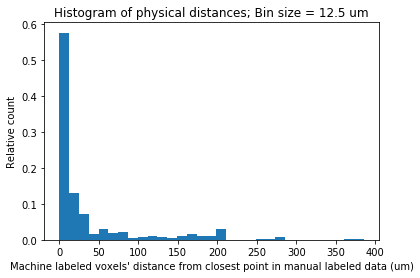

In [5]:
labeled_0_nz_voxel_ids = np.genfromtxt('./doc/tractography_'+test_lbl+'.swc' , delimiter=' ')
plot_quantification('./doc/tractography_'+test_lbl+'.swc',skeleton, 0.585, 0.585, 5.0)


## Save overlaid tiff volume for visualization
The saved tiff stack contains overlain raw, results and the labeled 

In [ ]:
overlaidFileName = '../output_data/test_tractography/test_'+test_lbl+'_overlaid_80th_sub-to-10k.tiff'

cmap = plt.cm.get_cmap('nipy_spectral' , np.unique(concomp).size)
overlaid = color.gray2rgb(img_as_ubyte(data_cutout_raw))
overlaid[skeleton != 0] = np.asarray([255,0,0], dtype='uint8')

for row in labeled_0_nz_voxel_ids:
    if np.array_equal(overlaid[row[0] , row[1] , row[2],:] , np.asarray([255,0,0], dtype='uint8')):
        overlaid[row[0] , row[1] , row[2],:] = np.asarray([255,255,0], dtype='uint8')
    else:
        overlaid[row[0] , row[1] , row[2],:] = np.asarray([0,255,0], dtype='uint8')
                                                          
imsave(overlaidFileName , overlaid)

## Save results as swc

In [ ]:
swcFileName = '../output_data/test_tractography/CSV_outputs/test_4_output_nosubs.swc'

unique_vals = np.unique(concomp)

clust_ids = np.empty((unique_vals.shape[0]-1))
outputmat = np.empty(((0,3)))
for i,cluster in enumerate(unique_vals[1:]):
        curr_clust = np.asarray(np.where( concomp == cluster )).T
        clust_ids[i] = curr_clust.shape[0]
        outputmat = np.append(outputmat , curr_clust, axis=0)


clust_ids = np.append([0] , np.cumsum(clust_ids)[:-1])

first_col = np.arange(1, outputmat.shape[0]+1).reshape(outputmat.shape[0],1)
second_col = 3*np.ones((outputmat.shape[0],1))
outputmat = np.append(second_col,outputmat, axis=1)
outputmat = np.append(first_col,outputmat, axis=1)

second_to_last_col = np.ones((outputmat.shape[0],1))
outputmat = np.append(outputmat, second_to_last_col, axis=1)
last_col = np.arange(outputmat.shape[0]).reshape(outputmat.shape[0],1)
last_col[np.uint16(clust_ids)] = -1
outputmat = np.append(outputmat, last_col ,axis=1)

np.savetxt(swcFileName , outputmat, fmt='%i')

## Ingest to Boss
Upload the results back to Boss


In [11]:

# Helper functions for ingestation (C: vikram)
def get_channel_resource(rmt, chan_name, coll_name, exp_name, type='image', base_resolution=0, sources=[], datatype='uint16', new_channel=True):
    channel_resource = ChannelResource(chan_name, coll_name, exp_name, type=type, 
                                    base_resolution=base_resolution, sources=sources, datatype=datatype)
    if new_channel: 

        new_rsc = rmt.create_project(channel_resource)
        return new_rsc

    return channel_resource



def upload_to_boss(rmt, data, channel_resource, resolution=0):
    Z_LOC = 0
    size = data.shape
    for i in range(0, data.shape[Z_LOC], 16):
        last_z = i+16
        if last_z > data.shape[Z_LOC]:
            last_z = data.shape[Z_LOC]
        print(resolution, [0, size[2]], [0, size[1]], [i, last_z])
        rmt.create_cutout(channel_resource, resolution, [0, size[2]], [0, size[1]], [i, last_z], np.asarray(data[i:last_z,:,:], order='C'))
        
        
# Ingest the results back to Boss
rmt = BossRemote()
new_coll_name = 'tractography'
new_exp_name = 'mvpsprint3'
new_chan_name = 'annot_4'
create_new_channel = False

if create_new_channel:
    # new channel
    new_chan_resource = get_channel_resource(rmt, new_chan_name, new_coll_name, new_exp_name , new_channel=True)
    upload_to_boss(rmt, concomp, new_chan_resource)
    
else:
    # get existing channel
    chan_resource = rmt.get_channel(chan_name= new_chan_name, coll_name=new_coll_name, exp_name=new_exp_name)
    upload_to_boss(rmt, concomp, chan_resource)


(0, [0, 100], [0, 500], [0, 16])
(0, [0, 100], [0, 500], [16, 32])
(0, [0, 100], [0, 500], [32, 48])
(0, [0, 100], [0, 500], [48, 64])
(0, [0, 100], [0, 500], [64, 80])
(0, [0, 100], [0, 500], [80, 96])
(0, [0, 100], [0, 500], [96, 112])
(0, [0, 100], [0, 500], [112, 128])
(0, [0, 100], [0, 500], [128, 144])
(0, [0, 100], [0, 500], [144, 160])
(0, [0, 100], [0, 500], [160, 176])
(0, [0, 100], [0, 500], [176, 192])
(0, [0, 100], [0, 500], [192, 208])
(0, [0, 100], [0, 500], [208, 224])
(0, [0, 100], [0, 500], [224, 240])
(0, [0, 100], [0, 500], [240, 256])
(0, [0, 100], [0, 500], [256, 272])
(0, [0, 100], [0, 500], [272, 288])
(0, [0, 100], [0, 500], [288, 304])
(0, [0, 100], [0, 500], [304, 320])
(0, [0, 100], [0, 500], [320, 336])
(0, [0, 100], [0, 500], [336, 352])
(0, [0, 100], [0, 500], [352, 368])
(0, [0, 100], [0, 500], [368, 384])
(0, [0, 100], [0, 500], [384, 400])
(0, [0, 100], [0, 500], [400, 416])
(0, [0, 100], [0, 500], [416, 432])
(0, [0, 100], [0, 500], [432, 448])
(0, [0

# Simulation and Metrics

In [ ]:
import tifffile as tiff

from cobalt_tractography import tractogen
from cobalt_tractography import tractometrics

## Generating simulated tracts and plotting on tif

In [ ]:
sim_file_name = 'demo.tif'
# [z, y, x]
pts1 = tractogen.gen_points([47, 350, 240], num_segs=75, seg_len=20)
pts2 = tractogen.gen_points([78, 300, 400], num_segs=50, seg_len=20)
pts3 = tractogen.gen_points([10, 130, 120], num_segs=50, seg_len=20)
curves = [pts1, pts2, pts3]
arr = tractogen.plot_curves_on_tif(curves, sim_file_name, shape=[100, 500, 500], return_array=True)

## Reading in simulated data

In [ ]:
data_cutout_raw = tiff.imread(sim_file_name)
data_cutout_raw = np.transpose(img_as_uint(data_cutout_raw),(1,2,0))
print(data_cutout_raw.shape)

## Running Tractography Algorithm

In [ ]:
th = tractoHandler(data_cutout_raw)
skeleton, concomp, concomp_col, data_cutout_binarized =th.run_tractography(1)

## Visualize (animated)
Visualize as an animation iterating through z slices

In [ ]:
# Visualize the output (animation)

from matplotlib import animation
from IPython.display import HTML

z_rng = [0 , data_cutout_raw.shape[2]]
# z_rng = [70,80]
fig, (im1, im2) = plt.subplots(1, 2)

# fig.set_facecolor('black')
ax1 = im1.imshow(data_cutout_raw[:,:,0], animated=True)
ax2 = im2.imshow(data_cutout_binarized[:,:,0], animated=True)

im1.get_xaxis().set_visible(False)
im2.get_xaxis().set_visible(False)

im1.get_yaxis().set_visible(False)
im2.get_yaxis().set_visible(False)

im1.set_title('Raw data')
im2.set_title('Weights')

def animate(i):
    ax1.set_data(data_cutout_raw[:,:,i])
    im1.set_title('Raw data; Z= ' + str(i))
#     ax1.set_cmap('gray')
    ax1.autoscale()
    
    ax2.set_data(data_cutout_binarized[:,:,i])
    im2.set_title('Weights; Z=' + str(i))
#     ax2.set_cmap('gray')
    ax2.autoscale()
    return ax1

anim = animation.FuncAnimation(fig, animate, frames = np.arange(z_rng[0],z_rng[1]), interval = 50)
HTML(anim.to_jshtml())


## Save results as swc


In [ ]:
swcFileName = 'demo_prediction.swc'

unique_vals = np.unique(concomp)

clust_ids = np.empty((unique_vals.shape[0]-1))
outputmat = np.empty(((0,3)))
for i,cluster in enumerate(unique_vals[1:]):
        curr_clust = np.asarray(np.where( concomp == cluster )).T
        clust_ids[i] = curr_clust.shape[0]
        outputmat = np.append(outputmat , curr_clust, axis=0)


clust_ids = np.append([0] , np.cumsum(clust_ids)[:-1])

first_col = np.arange(1, outputmat.shape[0]+1).reshape(outputmat.shape[0],1)
second_col = 3*np.ones((outputmat.shape[0],1))
outputmat = np.append(second_col,outputmat, axis=1)
outputmat = np.append(first_col,outputmat, axis=1)

second_to_last_col = np.ones((outputmat.shape[0],1))
outputmat = np.append(outputmat, second_to_last_col, axis=1)
last_col = np.arange(outputmat.shape[0]).reshape(outputmat.shape[0],1)
last_col[np.uint16(clust_ids)] = -1
outputmat = np.append(outputmat, last_col ,axis=1)

np.savetxt(swcFileName , outputmat, fmt='%i')

In [ ]:
pred_curves = tractogen.swc_to_curves('demo_prediction.swc')
gt_curves = curves

## Metrics

In [ ]:
pred_fv = tractometrics.compute_feature_vector(pred_curves, show_histogram=True)

In [ ]:
gt_fv = tractometrics.compute_feature_vector(gt_curves, show_histogram=True)